In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.stats import f,t
import itertools

In [7]:
from google.colab import files

uploaded = files.upload()

Saving oil_model_weekly_data.csv to oil_model_weekly_data.csv


# Valuing Hard Commodities in Dynamic Climate
---
## Part 2: Reviewing Forecasting Approaches
- **Reference**: [Series 1: Crude Oil within the Context of Oligopoly Market](https://github.com/florencex5/Crude_Oil_Finance_Project)
- **Period**: from Jan 2020 to May 2023
- **Target Variable**: Weekly Crude Oil WTI sport price
- **Key Features**: Weekly Refiner Production, Blender Production, Imports, Exports and Stock Levels
- **Model used**: XGBoost
- **Content**
  1. **Preliminary Analysis**
  2. **Enhancing Model Interpretability: Comparing Multiple Regression and XGBoost**
  3. **Performance Evaluation: Comparing Multiple Regression and LSTM**

In [34]:
df = pd.read_csv('oil_model_weekly_data.csv')
df.head()

,date,oil_spot_price_weekly,sum_refiner,sum_blender,sum_export,sum_import,sum_stock,natural_gas_spot,brent_spot
0,2010-06-06,72.9075,24800,26749,1819,51704,377915,4.44,72.71
1,2010-06-13,73.4360,24507,27442,1819,52709,378613,4.73,72.76
2,2010-06-20,76.7000,24736,27717,2058,55208,381991,5.10,76.22
3,2010-06-27,77.0600,25214,27856,2058,52633,386192,4.93,76.64
4,2010-07-04,74.9580,24559,28932,2058,53085,384178,4.66,73.86


## 1. Preliminary Analysis
---
- **Scatter Plot Matrix**
  - A clear diagonal pattern indicates a linear relationship between Brent and WTI prices.
  - Strong positive correlation observed between weekly imports and refiner production.
- **Correlation Analysis**
  - Confirms additional multicollinearity concerns:
    - Export & Refiner Production: -0.663
    - Export & Import: -0.704
    - Export & Stock: -0.609
    - Import & Refiner Production: 0.722
  - Multicollinearity issues arise due to the strong interdependence of supply chain-related features.


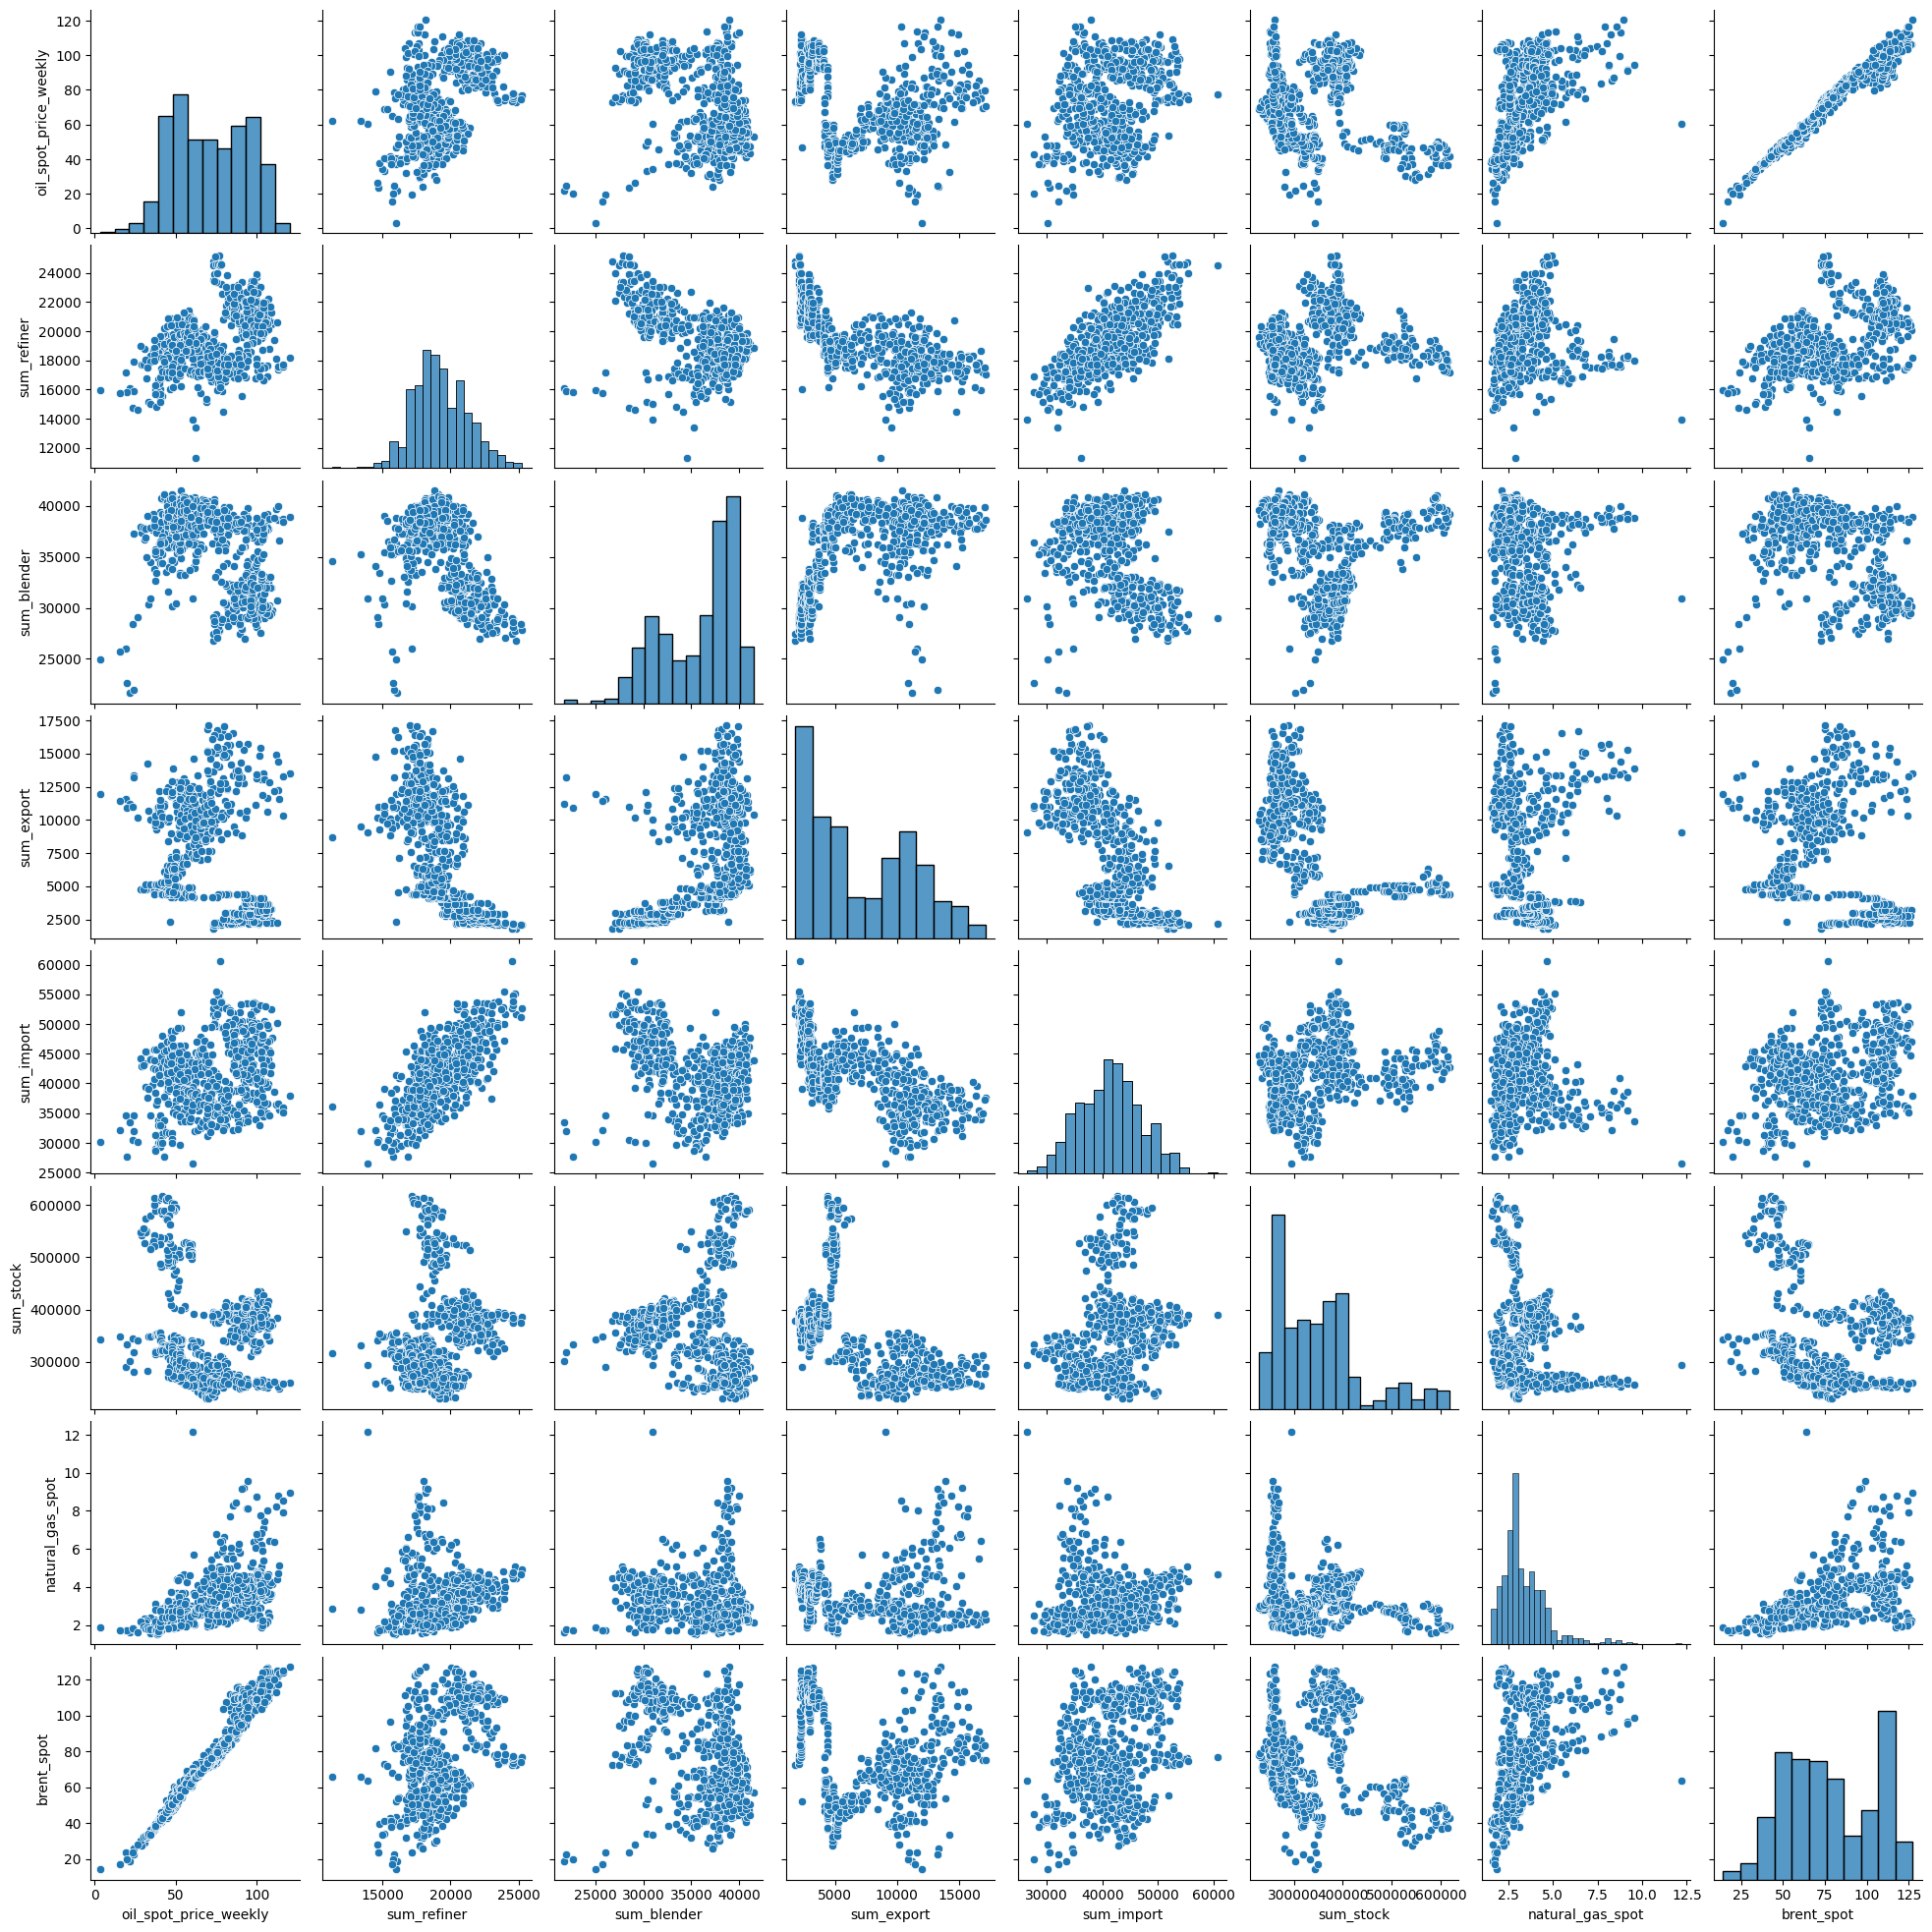

In [9]:
# Scatterplot Matrix
sns.pairplot(df)
plt.show()

In [10]:
# Correlation Table
correlation_matrix = df.drop(columns=['date']).corr()
correlation_matrix

,oil_spot_price_weekly,sum_refiner,sum_blender,sum_export,sum_import,sum_stock,natural_gas_spot,brent_spot
oil_spot_price_weekly,1.000000,0.466260,-0.390470,-0.270880,0.274031,-0.164682,0.559950,0.981112
sum_refiner,0.466260,1.000000,-0.506146,-0.663216,0.721627,0.187692,0.141133,0.503752
sum_blender,-0.390470,-0.506146,1.000000,0.546047,-0.379526,-0.151364,-0.063555,-0.436906
sum_export,-0.270880,-0.663216,0.546047,1.000000,-0.703583,-0.608658,0.041618,-0.306166
sum_import,0.274031,0.721627,-0.379526,-0.703583,1.000000,0.307913,-0.031684,0.310291
sum_stock,-0.164682,0.187692,-0.151364,-0.608658,0.307913,1.000000,-0.233367,-0.155356
natural_gas_spot,0.559950,0.141133,-0.063555,0.041618,-0.031684,-0.233367,1.000000,0.505185
brent_spot,0.981112,0.503752,-0.436906,-0.306166,0.310291,-0.155356,0.505185,1.000000


In [11]:
# Find pairs with high correlation (absolute value > 0.6)
high_corr_pairs = []
threshold = 0.6

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))


if high_corr_pairs:
    print("Highly correlated variable pairs (|correlation| > 0.6):")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} and {var2}: {corr:.3f}")
else:
    print("No pairs found with |correlation| > 0.6.")

Highly correlated variable pairs (|correlation| > 0.6):
oil_spot_price_weekly and brent_spot: 0.981
sum_refiner and sum_export: -0.663
sum_refiner and sum_import: 0.722
sum_export and sum_import: -0.704
sum_export and sum_stock: -0.609


## 2. Enhancing Model Interpretability: Comparing Multiple Regression and XGBoost
---
- **Content**
  - **2.1 Regression Model (Full features set)**
  - **2.2 Assumption Checks**
  - **2.3 Influence Analysis**
  - **2.4 Performance Comparison Across Factor Combinations**


### 2.1 Regression Model (Full features set)
---
- **Statistical Analysis**
  - **XGBoost Performance Overview [(Reference Link)](https://github.com/florencex5/Crude_Oil_Finance_Project)**:
    - Scenario A (All features included):
        - Mean Squared Error (MSE) : 8.845
        - Root Mean Squared Error (RMSE) : 2.974
        - R-squared (R2) : 0.983
    - Scenario B (Excluding highly correlated feature – Crude Oil Brent):
      - Mean Squared Error (MSE) : 25.638
      - Root Mean Squared Error (RMSE) : 5.063
      - R-squared (R2) : 0.952
  - **OLS Regression Analysis**
    - Minimal difference observed between R-squared and adjusted R-squared.
    - Given the low **RMSE** of 3.9538, the higher **AIC** and **BIC** values, primarily influenced by the large sample size, do not necessarily suggest poor model fit.
- **Model Comparison Analysis**
  - XGBoost, unlike multiple regression, operates without strict assumptions and demonstrates greater resilience to extreme values, making it particularly suited for hard commodity markets, especially amid the uncertainties of climate change. However, its performance is highly reliant on data preprocessing and selection. In this case, the model’s strong results were partially driven by dataset scaling before splitting and shuffling, which disrupted the chronological order.This introduced the risk of data leakage, where training data incorporated future observations, raising concerns about the model’s predictive reliability.
  - Moreover, the similar R-squared values (XGBoost: 0.983 vs. Multiple Regression: 0.969) call into question the true value of performance metrics, necessitating further evaluation.

In [12]:
formula = 'oil_spot_price_weekly ~ sum_refiner + sum_blender + sum_export + sum_import + sum_stock + natural_gas_spot + brent_spot'

model = ols(formula, data=df).fit()

print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     oil_spot_price_weekly   R-squared:                       0.969
Model:                               OLS   Adj. R-squared:                  0.969
Method:                    Least Squares   F-statistic:                     3087.
Date:                   Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                           01:32:55   Log-Likelihood:                -1941.6
No. Observations:                    695   AIC:                             3899.
Df Residuals:                        687   BIC:                             3935.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

In [13]:
# Calculate RMSE
y_actual = df['oil_spot_price_weekly'].values

y_pred_reg = model.predict(df)

rmse_reg = np.sqrt(mean_squared_error(y_actual, y_pred_reg))
print(f'Regression RMSE: {rmse_reg:.4f}')

Regression RMSE: 3.9538


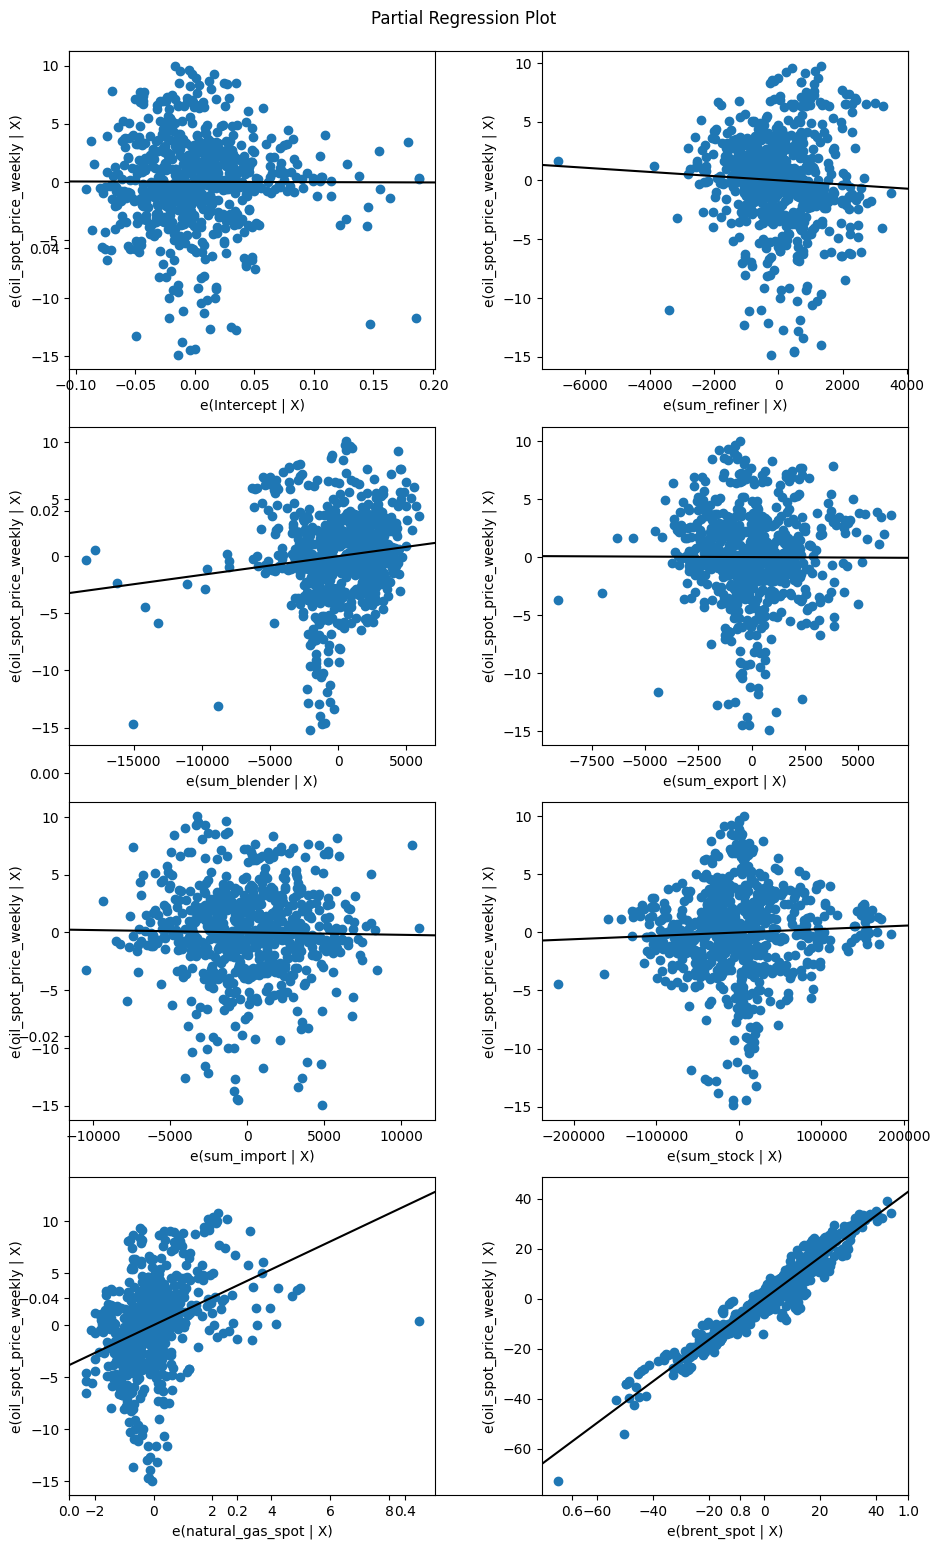

In [14]:
# Residual Analysis

fig, ax = plt.subplots(figsize=(10,16))

fig = sm.graphics.plot_partregress_grid(model, fig=fig)

for ax in fig.axes:
    ax.autoscale(enable=True, axis='y')

fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

plt.show()

### 2.2 Assumption Checks
---
- **Homoskedasticity**: Residual analysis indicates potential issues with factor weekly natural gas as well as weekly Brent spot prices, further confirmed by the BP test.
- **Serial Correlation**: The BG test is used to verify autocorrelation concerns, as the DW test (0.16) indicates positive autocorrelation but may be limited by its reliance on lagged Y values.
- **Multicollinearity**:
    - Further highlighted through VIF values, which greater than 10 across all factors, with weekly refined production showing the highest VIF of 187.140, indicating significant multicollinearity.
    - While increasing sample size could mitigate multicollinearity, the inflated **AIC** and **BIC** values suggest it is inherent, driven by feature selection.



In [15]:
# Perform the BP test - Homoskedasticity

bp_test = het_breuschpagan(model.resid, model.model.exog)

bp_stat = bp_test[0]
bp_p_value = bp_test[1]

print("\nBreusch-Pagan test for heteroskedasticity:")
print(f"Test Statistic: {bp_stat:.4f}")
print(f"P-value: {bp_p_value:.4f}")

if bp_p_value < 0.05:
    print("Heteroskedasticity detected (reject null hypothesis).")
else:
    print("No significant heteroskedasticity detected (fail to reject null hypothesis).")


Breusch-Pagan test for heteroskedasticity:
Test Statistic: 170.7062
P-value: 0.0000
Heteroskedasticity detected (reject null hypothesis).


In [16]:
# Perform the BG test for autocorrelation
bg_test = acorr_breusch_godfrey(model, nlags=1)

print("\nBreusch-Godfrey test for autocorrelation:")
print(f"Test Statistic: {bg_test[0]:.4f}")
print(f"P-value: {bg_test[1]:.4f}")

if bg_test[1] < 0.05:
    print("Autocorrelation detected (reject null hypothesis).")
else:
    print("No significant autocorrelation detected (fail to reject null hypothesis).")


Breusch-Godfrey test for autocorrelation:
Test Statistic: 586.6192
P-value: 0.0000
Autocorrelation detected (reject null hypothesis).


In [18]:
# Perform VIF for multicollinearity
variables = df[['sum_refiner', 'sum_blender', 'sum_export', 'sum_import', 'sum_stock', 'natural_gas_spot', 'brent_spot']]

vif_data = pd.DataFrame()
vif_data['Variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif_data

,Variable,VIF
0,sum_refiner,187.140106
1,sum_blender,111.672283
2,sum_export,12.607574
3,sum_import,143.640652
4,sum_stock,27.035439
5,natural_gas_spot,10.964020
6,brent_spot,20.129991


### 2.3 Influence Analysis
---
- Following the removal of significant studentized residuals, the model demonstrated a modest improvement, with the adjusted R-squared rising from 0.969 to 0.981, and both AIC and BIC values decreasing (AIC from 3899 to 3321, BIC from 3935 to 3357).
- Outliers play a critical role in forecasting hard commodities, as their effects can extend beyond the immediate dataset. In LSTM models, which rely on sequential data, the removal of outliers can disrupt this sequence, potentially leading to a cascade of inaccurate forecasts, as the model may adapt to patterns that no longer reflect the underlying trends.
- Handling outliers requires careful consideration—whether through “removal” or “winsorization”—particularly in light of industry-specific factors.

In [19]:
influence = model.get_influence()

influence_summary = influence.summary_frame()
influence_summary

,dfb_Intercept,dfb_sum_refiner,dfb_sum_blender,dfb_sum_export,dfb_sum_import,dfb_sum_stock,dfb_natural_gas_spot,dfb_brent_spot,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.038719,0.157707,-0.143691,0.062594,0.027151,-0.001702,0.113105,-0.188319,0.011207,1.778522,0.027562,0.299421,1.781333,0.299894
1,-0.041623,0.131372,-0.134343,0.060297,0.054891,-0.002342,0.131509,-0.187506,0.010621,1.765353,0.026540,0.291489,1.768082,0.291940
2,-0.072060,0.120180,-0.136223,0.092481,0.103980,0.017203,0.151947,-0.183905,0.012074,1.753499,0.030457,0.310789,1.756156,0.311260
3,-0.081954,0.178364,-0.124997,0.084340,0.039951,0.020321,0.137172,-0.187665,0.012432,1.812874,0.029373,0.315366,1.815903,0.315893
4,-0.073353,0.146401,-0.110403,0.069262,0.063316,0.006997,0.129800,-0.182269,0.010920,1.880989,0.024096,0.295567,1.884479,0.296115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,-0.034954,0.005881,0.008384,0.061153,0.016936,0.024118,-0.045855,0.050068,0.001155,0.870990,0.012035,0.096132,0.870837,0.096115
691,-0.048989,0.006508,-0.009206,0.097643,0.037170,0.044072,-0.049959,0.059952,0.001988,0.942653,0.017586,0.126120,0.942577,0.126110
692,-0.025062,-0.046125,0.013674,0.059418,0.068254,0.004623,-0.069662,0.083720,0.002574,1.382534,0.010658,0.143494,1.383453,0.143590
693,-0.063027,0.027758,-0.006163,0.119096,0.015720,0.058190,-0.072290,0.088628,0.003386,1.280123,0.016260,0.164576,1.280719,0.164653


In [25]:
# Detect high leverage points
k = 7  # Number of independent variables
n = 695  # Total number of observations
threshold = 3 * ((k + 1) / n)

influence_summary[influence_summary['hat_diag'] > threshold]

,dfb_Intercept,dfb_sum_refiner,dfb_sum_blender,dfb_sum_export,dfb_sum_import,dfb_sum_stock,dfb_natural_gas_spot,dfb_brent_spot,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
7,-0.125446,0.073519,-0.142271,0.151340,0.244540,0.038059,0.153912,-0.178988,0.018695,2.006360,0.035822,0.386725,2.010799,0.387581
378,-0.125812,0.101492,-0.056353,0.174548,0.026985,0.134955,-0.007879,0.035636,0.004749,-0.975789,0.038367,-0.194908,-0.975755,-0.194901
512,-0.104004,0.005065,0.161666,-0.043098,0.003468,0.012988,-0.003025,0.095598,0.004468,-0.953473,0.037833,-0.189068,-0.953410,-0.189056
513,0.146858,-0.036069,-0.209505,0.042832,0.004053,-0.011501,0.011419,-0.104988,0.006782,0.905177,0.062105,0.232926,0.905058,0.232896
514,0.099000,-0.020899,-0.170140,0.060552,0.005616,0.016292,0.007715,-0.070446,0.004287,0.706011,0.064373,0.185187,0.705753,0.185120
515,0.013790,-0.001337,-0.017065,0.001751,-0.004849,-0.000467,0.000501,-0.008540,0.000052,0.081241,0.059506,0.020435,0.081182,0.020420
516,-0.419717,0.033910,0.614917,-0.148371,0.092535,-0.035665,-0.050526,0.344646,0.064416,-3.148194,0.049425,-0.717865,-3.168843,-0.722573
517,-0.070269,0.016597,0.098503,-0.022604,0.004970,-0.004371,-0.005667,0.052175,0.001647,-0.539610,0.043289,-0.114782,-0.539331,-0.114723
559,-0.550690,0.370817,0.375658,0.288404,0.103034,0.120882,-1.046400,0.525998,0.181044,-3.140563,0.128043,-1.203475,-3.161050,-1.211326
560,0.017999,-0.024108,-0.005671,-0.007592,0.007500,-0.005223,0.000044,0.003881,0.000079,0.106449,0.052930,0.025165,0.106372,0.025147


In [33]:
# Detect outliers (extreme value dependent variable)
alpha = 0.05  # Significance level for a two-tailed test

Df = n - k - 1

t_critical = t.ppf(1 - alpha/2, Df)

influence_summary[abs(influence_summary['student_resid'])>t_critical ]

,dfb_Intercept,dfb_sum_refiner,dfb_sum_blender,dfb_sum_export,dfb_sum_import,dfb_sum_stock,dfb_natural_gas_spot,dfb_brent_spot,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
6,-0.074596,0.134291,-0.136526,0.091563,0.103482,0.005552,0.125663,-0.184726,0.012710,1.961398,0.025749,0.318867,1.965481,0.319531
7,-0.125446,0.073519,-0.142271,0.151340,0.244540,0.038059,0.153912,-0.178988,0.018695,2.006360,0.035822,0.386725,2.010799,0.387581
8,-0.080849,0.140881,-0.125302,0.087443,0.087381,0.016041,0.137958,-0.180868,0.012131,1.962200,0.024587,0.311530,1.966289,0.312179
20,-0.007094,-0.017632,-0.095536,0.038698,0.136569,0.003840,0.039555,-0.066218,0.005606,2.090047,0.010162,0.211766,2.095197,0.212287
21,0.050731,-0.010197,-0.096435,-0.013165,0.039385,-0.009109,0.022977,-0.053144,0.003413,2.117499,0.006053,0.165240,2.122897,0.165661
22,0.045822,0.047599,-0.081756,-0.028923,-0.034920,-0.012140,0.012427,-0.051257,0.003482,2.136809,0.006063,0.166895,2.142385,0.167331
23,0.064655,0.048663,-0.077137,-0.054996,-0.061217,-0.031077,0.027569,-0.057708,0.003929,2.149080,0.006760,0.177301,2.154771,0.177770
30,0.023942,0.130841,-0.103810,-0.014810,-0.066529,-0.043076,0.047901,-0.096940,0.006913,2.024375,0.013316,0.235175,2.028961,0.235707
54,0.044350,0.022752,0.019345,-0.023945,-0.091183,-0.027628,-0.036626,-0.053907,0.004068,-2.059958,0.007610,-0.180393,-2.064845,-0.180821
61,0.037560,-0.005965,-0.002194,0.011484,-0.055587,0.009151,-0.015908,-0.046438,0.004017,-2.342605,0.005822,-0.179266,-2.350306,-0.179855


In [30]:
# Detect influential points based on Cook's Distance
cook_d_threshold = np.sqrt(k / n)

influence_summary[influence_summary['cooks_d'] > cook_d_threshold]

,dfb_Intercept,dfb_sum_refiner,dfb_sum_blender,dfb_sum_export,dfb_sum_import,dfb_sum_stock,dfb_natural_gas_spot,dfb_brent_spot,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
559,-0.55069,0.370817,0.375658,0.288404,0.103034,0.120882,-1.0464,0.525998,0.181044,-3.140563,0.128043,-1.203475,-3.16105,-1.211326


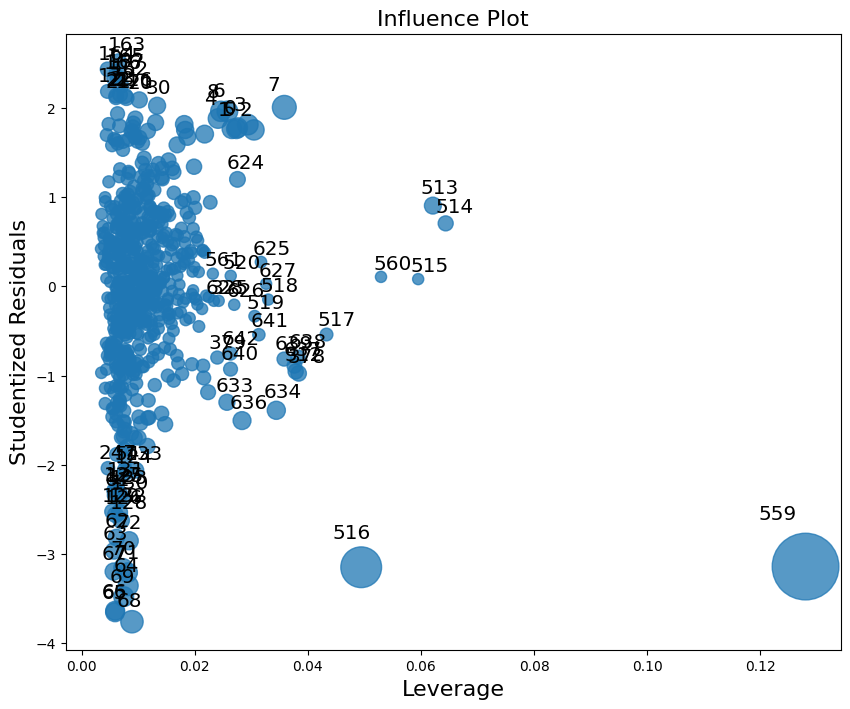

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
influence.plot_influence(ax=ax)

plt.show()

In [37]:
# Multiple Regression Model (after excluding observations with significant studentized residuals)
influential_points = influence_summary[abs(influence_summary['student_resid']) > t_critical]

filtered_df = df.drop(index=influential_points.index)

formula2 = 'oil_spot_price_weekly ~ sum_refiner + sum_blender + sum_export + sum_import + sum_stock + natural_gas_spot + brent_spot'

model2 = ols(formula2, data=filtered_df).fit()

print(model2.summary())

                              OLS Regression Results                             
Dep. Variable:     oil_spot_price_weekly   R-squared:                       0.981
Model:                               OLS   Adj. R-squared:                  0.981
Method:                    Least Squares   F-statistic:                     4851.
Date:                   Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                           03:18:33   Log-Likelihood:                -1652.5
No. Observations:                    651   AIC:                             3321.
Df Residuals:                        643   BIC:                             3357.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

### 2.4 Performance Comparison Across Factor Combinations
---
- The analysis highlights that in forecasting hard commodities, factor quality is more critical than quantity. Brent spot price consistently achieves the highest t-statistic across most models, reaffirming its importance in explaining WTI crude oil prices. Conversely, factors such as weekly imports and exports exhibit limited explanatory power, as indicated by their high p-values and low t-statistics.

In [21]:
dependent_var = 'oil_spot_price_weekly'
factors = ['sum_refiner', 'sum_blender', 'sum_export', 'sum_import', 'sum_stock', 'natural_gas_spot','brent_spot']

In [22]:
def evaluate_model(data, dependent_var, selected_factors):
    formula = f"{dependent_var} ~ {' + '.join(selected_factors)}"
    model = ols(formula, data=data).fit()

    print(f"\nModel Summary for formula: {formula}\n")
    print(model.summary())  # Print the full model summary
    print("-" * 130)

    rmse = (model.resid ** 2).mean() ** 0.5  # Calculate RMSE
    r_squared = model.rsquared
    adj_r_squared = model.rsquared_adj

    return formula, rmse, r_squared, adj_r_squared

In [23]:
def run_model_combinations(data, dependent_var, factors):
    results = []
    for r in range(2, len(factors) + 1):
        for combo in itertools.combinations(factors, r):
            formula, rmse, r_squared, adj_r_squared = evaluate_model(data, dependent_var, combo)
            results.append((formula, rmse, r_squared, adj_r_squared))

    print("\nSummary of Model Performance:")
    results.sort(key=lambda x: x[1])
    for formula, rmse, r_squared, adj_r_squared in results:
        print(f"Formula: {formula}")
        print(f"RMSE: {rmse:.4f}, R-squared: {r_squared:.4f}, Adjusted R-squared: {adj_r_squared:.4f}\n")

In [24]:
run_model_combinations(df, dependent_var, factors)


Model Summary for formula: oil_spot_price_weekly ~ sum_refiner + sum_blender

                              OLS Regression Results                             
Dep. Variable:     oil_spot_price_weekly   R-squared:                       0.249
Model:                               OLS   Adj. R-squared:                  0.247
Method:                    Least Squares   F-statistic:                     115.0
Date:                   Fri, 24 Jan 2025   Prob (F-statistic):           7.51e-44
Time:                           01:42:04   Log-Likelihood:                -3051.1
No. Observations:                    695   AIC:                             6108.
Df Residuals:                        692   BIC:                             6122.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------

## 3. Performance Evaluation: Comparing Multiple Regression and LSTM
---
- LSTM may not be the most suitable choice for forecasting hard commodities—not merely due to its slightly higher RMSE compared to multiple regression, but primarily because extensive tuning tends to optimize statistical accuracy while diminishing its ability to reflect climate-related factors and real-world dynamics.
- Over-smoothing from tuning can obscure market volatilities, while multiple regression, depending on feature selection and the analyzed time horizon, could provide more responsive predictions. However, LSTM remains valuable for capturing overall trends.

### Data Splitting

In [21]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size], df[train_size:len(df)]

### Multiple Linear Regression

In [22]:
# Training
X_train_reg = train_data[['sum_refiner', 'sum_blender', 'sum_export', 'sum_import', 'sum_stock', 'natural_gas_spot', 'brent_spot']]
y_train_reg = train_data['oil_spot_price_weekly']

# Testing
X_test_reg = test_data[['sum_refiner', 'sum_blender', 'sum_export', 'sum_import', 'sum_stock', 'natural_gas_spot', 'brent_spot']]
y_test_reg = test_data['oil_spot_price_weekly']

In [23]:
X_train_reg = sm.add_constant(X_train_reg)
X_test_reg = sm.add_constant(X_test_reg)

In [24]:
regression_model = sm.OLS(y_train_reg, X_train_reg).fit()

In [25]:
y_pred_reg = regression_model.predict(X_test_reg)

In [26]:
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f'Multiple Regression Model RMSE: {rmse_reg:.4f}')

Multiple Regression Model RMSE: 5.4197


In [27]:
print(regression_model.summary())

                              OLS Regression Results                             
Dep. Variable:     oil_spot_price_weekly   R-squared:                       0.971
Model:                               OLS   Adj. R-squared:                  0.971
Method:                    Least Squares   F-statistic:                     2620.
Date:                   Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                           22:11:45   Log-Likelihood:                -1560.7
No. Observations:                    556   AIC:                             3137.
Df Residuals:                        548   BIC:                             3172.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

### LSTM Model

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data[['oil_spot_price_weekly']])
test_data_scaled = scaler.transform(test_data[['oil_spot_price_weekly']])


In [30]:
timesteps = 10

def create_dataset(data, timesteps=10):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


In [31]:

X_train_lstm, y_train_lstm = create_dataset(train_data_scaled, timesteps)

X_test_lstm, y_test_lstm = create_dataset(test_data_scaled, timesteps)

In [32]:

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [33]:
def build_lstm_model(hp):
    model = Sequential()

    units = hp.Int('units', min_value=50, max_value=200, step=50)
    model.add(Input(shape=(X_train_lstm.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=True))


    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [34]:

tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

In [35]:

tuner.search(X_train_lstm, y_train_lstm, epochs=20, validation_data=(X_test_lstm, y_test_lstm), batch_size=32)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Units: {best_hps.get('units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")


Trial 30 Complete [00h 00m 16s]
val_loss: 0.004590070806443691

Best val_loss So Far: 0.003570870030671358
Total elapsed time: 00h 05m 39s
Best Units: 100
Best Dropout Rate: 0.2
Best Optimizer: adam


In [36]:
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(X_train_lstm, y_train_lstm, epochs=50, validation_data=(X_test_lstm, y_test_lstm), batch_size=32)

loss = best_model.evaluate(X_test_lstm, y_test_lstm)
print(f"Final Test Loss: {loss}")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.1665 - val_loss: 0.0232
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0170 - val_loss: 0.0048
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [37]:
y_pred_lstm = best_model.predict(X_test_lstm)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


In [38]:

y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

In [39]:

rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled))
print(f'LSTM Model RMSE: {rmse_lstm:.4f}')


LSTM Model RMSE: 5.8067


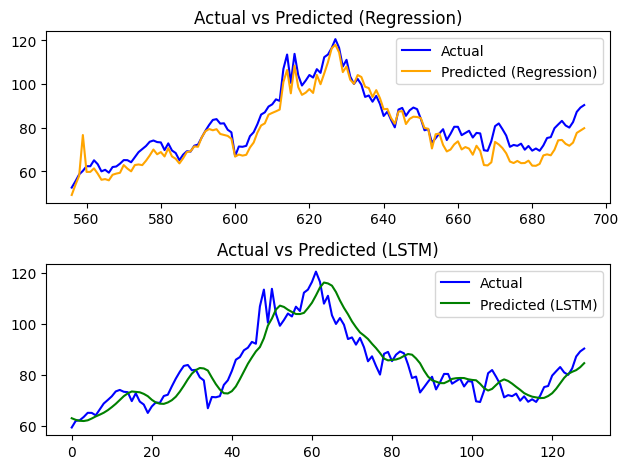

In [40]:
# Plot for Regression
plt.subplot(2, 1, 1)
plt.plot(y_test_reg, label='Actual', color='blue')
plt.plot(y_pred_reg, label='Predicted (Regression)', color='orange')
plt.title('Actual vs Predicted (Regression)')
plt.legend()

# Plot for LSTM
plt.subplot(2, 1, 2)
plt.plot(y_test_lstm_rescaled, label='Actual', color='blue')  # Align the dates for LSTM
plt.plot(y_pred_lstm_rescaled, label='Predicted (LSTM)', color='green')
plt.title('Actual vs Predicted (LSTM)')
plt.legend()


plt.tight_layout()
plt.show()